In [8]:
from __future__ import division
import numpy as np
import csv
np.random.seed(0)
import matplotlib.pyplot as plt

In [2]:
def top_k(A,B,K):
    # calculate norms of the columns of A and rows of B
    a_col_norms = np.linalg.norm(A,axis=0)
    b_row_norms = np.linalg.norm(B,axis=1)
    
    # multiply both norms element-wise to and pick the indices of the top K column-row pairs
    norm_mult = np.multiply(a_col_norms,b_row_norms)
    top_k_indices = np.sort(np.argsort(norm_mult)[::-1][:K])
    
    # pick top-k column-row pairs to form new smaller matrices
    A_top_k_cols = A[:,top_k_indices]
    B_top_k_rows = B[top_k_indices,:]
       
    # multiply smaller matrices
    C_approx = np.dot(A_top_k_cols, B_top_k_rows)
    return C_approx

In [6]:
''' A,B - input matrices
    K - number of column-row elements to sample
    with_replacement - True means sampling is done with replacement, False means sampling without replacement
    optimal_prob - True means sampling probability is proportional to |Ai|*|Bj|. False means random distribution
    scale - True means each column-row is scaled by 1/sqrt(K*pi) to ensure bias 0
'''
def column_row(A,B,K,with_replacement = True, optimal_prob = True, scale=True, debug=False):
    # calculate norms of the columns of A and rows of B
    a_col_norms = np.linalg.norm(A,axis=0)
    b_row_norms = np.linalg.norm(B,axis=1)
   
    # multiply both norms element-wise
    norm_mult = np.multiply(a_col_norms,b_row_norms)
    sum_norm_mult = np.sum(norm_mult)
    
    if optimal_prob == True and sum_norm_mult != 0:
        prob_dist = norm_mult/sum_norm_mult
    else:
        prob_dist = np.ones(A.shape[1])/A.shape[1] # uniform distributionwill be treated as uniform by np.random.choice 
    
    # scale input matrices according to probabilities.
    # For convenience we implement it by creating a diagonal matrix and multiplying (other implementations are possible).
    if scale == True:
        scale_matrix = np.diag(np.divide(1,np.sqrt(np.multiply(K,prob_dist))))
    else:
        scale_matrix = np.diag(np.ones(A.shape[1]))

    A_scaled = np.dot(A,scale_matrix)
    B_scaled = np.dot(scale_matrix,B)
    
    sample_indices = np.random.choice(A.shape[1], size=K, replace=with_replacement, p=prob_dist)
    
    # sample k column-row pairs to form new smaller matrices
    A_k_cols = A_scaled[:,sample_indices]
    B_k_rows = B_scaled[sample_indices,:]
       
    # multiply smaller matrices
    C_approx = np.dot(A_k_cols, B_k_rows)

    if debug == True:
        print ('a_col_norms is ' + str(a_col_norms))
        print ('b_row_norms is ' + str(b_row_norms))
        print ('norm_mult is ' + str(norm_mult))
        print ('sum_norm_mult is ' + str(sum_norm_mult))
        print ('prob_dist is ' + str(prob_dist))
        print ('scale matrix is ' + str(scale_matrix))
        print ('A_scaled is ' + str(A_scaled))
        print ('B_scaled is ' + str(B_scaled))
        print ('sample_indices are ' + str(sample_indices))
        print ('Frobenius error bound is '+ str(sum_norm_mult**2/K -  np.linalg.norm(A.dot(B)/K)))
        print ('A_k_cols is ')
        print (A_k_cols)
        print ('B_k_rows is ')
        print (B_k_rows)
        print ('C_approx is ')
        print (C_approx)
    
    return C_approx

In [4]:
''' A,B - input matrices
    K - sampling parameter
    scale - True means each column-row is scaled by 1/sqrt(pi) to ensure bias 0
'''
def column_row_bern(A,B,K, scale=True, debug=False):
    # calculate norms of the columns of A and rows of B
    a_col_norms = np.linalg.norm(A,axis=0)
    b_row_norms = np.linalg.norm(B,axis=1)
   
    # multiply both norms element-wise
    norm_mult = np.multiply(a_col_norms,b_row_norms)
    sum_norm_mult = np.sum(norm_mult)
    
    if sum_norm_mult != 0:
        prob_dist = K*norm_mult/sum_norm_mult
    else:
        prob_dist = np.ones(A.shape[1]) 
    
    prob_dist = np.clip(prob_dist,0,1)
    
    # scale input matrices according to probabilities.
    # For convenience we implement it by creating a diagonal matrix and multiplying (other implementations are possible).
    if scale == True:
        scale_matrix = np.diag(np.divide(1,np.sqrt(prob_dist)))
    else:
        scale_matrix = np.diag(np.ones(A.shape[1]))

    A_scaled = np.dot(A,scale_matrix)
    B_scaled = np.dot(scale_matrix,B)
    
    bern = np.random.binomial(1, prob_dist)
    
    sample_indices = np.where(bern == 1)[0]
    
    # sample k column-row pairs to form new smaller matrices
    A_k_cols = A_scaled[:,sample_indices]
    B_k_rows = B_scaled[sample_indices,:]
       
    # multiply smaller matrices
    C_approx = np.dot(A_k_cols, B_k_rows)
  
    if debug == True:
        print ('a_col_norms is ' + str(a_col_norms))
        print ('b_row_norms is ' + str(b_row_norms))
        print ('norm_mult is ' + str(norm_mult))
        print ('sum_norm_mult is ' + str(sum_norm_mult))
        print ('prob_dist is ' + str(prob_dist))
        print ('scale matrix is ' + str(scale_matrix))
        print ('A_scaled is ' + str(A_scaled))
        print ('B_scaled is ' + str(B_scaled))
        print ('sample_indices are ' + str(sample_indices))
        print ('num sampled indices is ' + str(len(sample_indices)))
        print ('Frobenius error bound is '+ str(sum_norm_mult**2/K - np.sum(np.multiply(np.multiply(a_col_norms,a_col_norms),np.multiply(b_row_norms,b_row_norms)))))
        print ('A_k_cols is ')
        print (A_k_cols)
        print ('B_k_rows is ')
        print (B_k_rows)
        print ('C_approx is ')
        print (C_approx)
    
    return C_approx

In [15]:
def get_stats(A,B,approx):
    
    
    # Calculate accurate multiplication result C=AB
    acc = np.dot(A,B)
    
    # Normalized Frobenius error F(acc-approx)/(F(A)F(B))
    normalized_frobenius_error= np.linalg.norm(acc-approx, ord='fro')/(np.linalg.norm(A, ord='fro')*np.linalg.norm(B, ord='fro'))
    
    
    
    return normalized_frobenius_error
    

In [31]:
# initialize 100x100 random matrices (~N(0,1)
M = 100
K = 100
N = 100

              

A = np.random.normal(loc=1, scale=1, size=(M,K))
        
B = np.random.normal(loc=1, scale=1, size=(K,N))

top_e = []
crs_e = []
bern_e =[]


repeat_experiments = 1000

for k in range(1,K+1,1): 
    
    err_top_k = 0
    err_crs = 0
    err_bern = 0
    for n in range(repeat_experiments):
        A = np.random.normal(loc=1, scale=1, size=(M,K))

        B = np.random.normal(loc=1, scale=1, size=(K,N))
        # Calculate the product AB using different approximation algorithms
        C_approx_top_k = top_k(A,B,k)
        err_top_k += get_stats(A,B,C_approx_top_k)
        

        C_approx_crs = column_row(A,B,k,with_replacement=True, optimal_prob=True, scale=True)
        err_crs += get_stats(A,B,C_approx_crs)
        


        C_approx_bern = column_row_bern(A,B,k, scale=True)
        err_bern += get_stats(A,B,C_approx_bern)
        
        
    top_e.append(err_top_k/1000)
    crs_e.append(err_crs/1000)
    bern_e.append(err_bern/1000)


In [32]:
top = np.array(top_e)
crs = np.array(crs_e)
bern = np.array(bern_e)

In [33]:
top.shape

(100,)

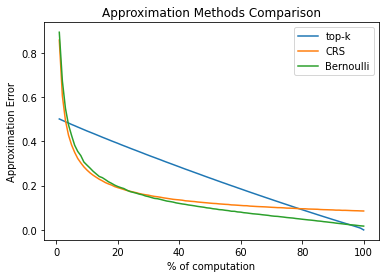

In [35]:
p = np.linspace(1, 100, 100)

plt.plot(p, top, label='top-k')
plt.plot(p, crs, label='CRS')
plt.plot(p, bern, label='Bernoulli')

plt.xlabel('% of computation')
plt.ylabel('Approximation Error')

plt.title("Approximation Methods Comparison")

plt.legend()
plt.savefig('app.png')
plt.show()

In [20]:
p

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])